In [1]:
!pip install timm -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import json
import warnings
warnings.filterwarnings('ignore')
with open('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json') as f:
  class_label_name = json.load(f)
class_label_name

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [3]:
class_name_label = {class_label_name[i]:i for i in class_label_name.keys()}
class_name_label

{'Cassava Bacterial Blight (CBB)': '0',
 'Cassava Brown Streak Disease (CBSD)': '1',
 'Cassava Green Mottle (CGM)': '2',
 'Cassava Mosaic Disease (CMD)': '3',
 'Healthy': '4'}

In [4]:
import pandas as pd
df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


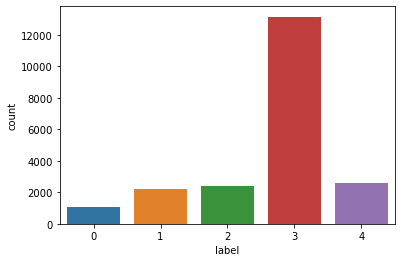

In [5]:
import seaborn as sns
sns.countplot(df.label)

In [6]:
import os
train_dir = '../input/cassava-leaf-disease-classification/train_images'
df['image_id'] = df['image_id'].apply(lambda x: os.path.join(train_dir,x))
df.head()

,image_id,label
0,../input/cassava-leaf-disease-classification/t...,0
1,../input/cassava-leaf-disease-classification/t...,3
2,../input/cassava-leaf-disease-classification/t...,1
3,../input/cassava-leaf-disease-classification/t...,1
4,../input/cassava-leaf-disease-classification/t...,3


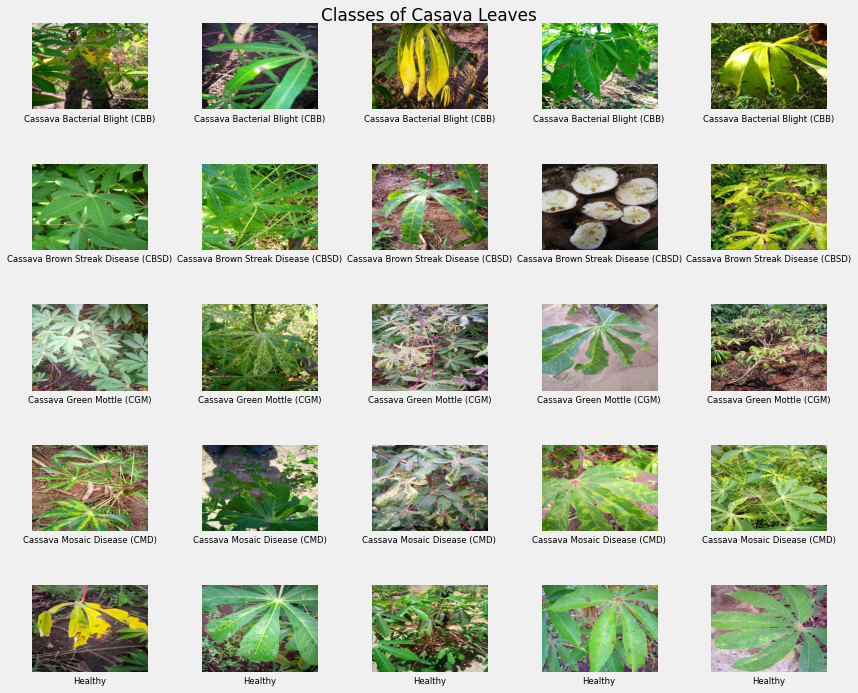

In [7]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,10))
photo_no= 1
plt.title('Classes of Casava Leaves')
for id in class_label_name.keys():
    count = 1
    for file_name, label in zip(df.image_id, df.label):
        if int(label) == int(id):
            plt.subplot(5,5,photo_no)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            img = plt.imread(file_name)
            plt.imshow(img)
            plt.xlabel(class_label_name[str(label)], fontsize=8.5)
            photo_no += 1
            count += 1
            if count == 6:
                break
plt.suptitle('Classes of Casava Leaves')
plt.tight_layout()
plt.show()

In [8]:
import numpy as np
mean=np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
max_size= 350
height,width = (300,300)

In [9]:
import torch
import timm
import shutil
from torch import nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as tfm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.backends.cudnn as cudnn
import albumentations as alb
from albumentations.pytorch import ToTensorV2
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy

In [10]:
train_transform= alb.Compose(
    [
        alb.SmallestMaxSize(max_size=max_size),
        alb.ShiftScaleRotate(p=0.5),
        alb.RandomCrop(height=height, width=width),
        alb.OneOf([alb.IAAAdditiveGaussianNoise(p=0.5),
                   alb.ISONoise(p=0.5),
                   alb.MultiplicativeNoise(p=0.5)], p=0.5),       
        #alb.IAAEmboss(p=0.5), #newone
        alb.Flip(p=0.5),
        alb.CLAHE(p=0.5), #newone
        alb.OneOf([alb.HueSaturationValue(p=0.5),
                  alb.ColorJitter(p=0.5),
                  alb.RGBShift(p=0.5)], p=0.5),     
        alb.CoarseDropout(p=0.5),
        alb.IAASharpen(p=0.5),#newone
        alb.OneOf([alb.RandomBrightnessContrast(p=0.5),
                   alb.RandomSunFlare(p=0.5)], p=0.5),
        alb.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]

)

val_transform= alb.Compose(
    [
        alb.SmallestMaxSize(max_size=max_size),
        alb.CenterCrop(height=height, width=width),
        alb.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]

)

In [11]:
import cv2

class CassavaImageDataset(Dataset):
    def __init__(self, data, transform=None):
        super().__init__()
        self.data = data.values
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_id, label = self.data[index]
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)['image']
        return image, label

In [12]:
train, val = train_test_split(df, stratify=df['label'], test_size=0.15, random_state=42)

In [13]:
train_data = CassavaImageDataset(train, train_transform)
val_data = CassavaImageDataset(val, val_transform)

In [14]:
train_loader = DataLoader(dataset=train_data, batch_size=40, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(dataset=val_data, batch_size=40, shuffle=False, num_workers=0, pin_memory=True)

In [15]:
class CassavaModel(pl.LightningModule):
    def __init__(self, data_dir='./train_images', learning_rate = 1e-4):
        super(CassavaModel, self).__init__()
        self.data_dir = data_dir
        self.learning_rate = learning_rate
        self.training_loss=[]
        self.training_acc=[]
        self.valid_loss =[]
        self.valid_acc =[]
                
        self.num_classes = 5
        self.model = timm.create_model('tf_efficientnet_b3_ns', pretrained=True)
        self.model.classifier = nn.Sequential(nn.Linear(1536,256),
                            nn.BatchNorm1d(256),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(256,5))

    def forward(self,x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate, weight_decay=1e-6)
        return {
            'optimizer':  optimizer,
            'lr_scheduler': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10,eta_min=1e-6),
            'monitor': 'val_loss'
        }
    
    #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    
    def step(self, batch):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        return loss, y, y_hat
    
    def training_step(self, batch, batch_idx):
        loss, y, y_hat = self.step(batch)
        return {'loss':loss, 'y':y, 'y_hat':y_hat}
          
    def validation_step(self, batch, batch_idx):
        loss, y, y_hat = self.step(batch)
        return {'loss':loss, 'y':y, 'y_hat':y_hat}
    
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        auc = self.get_auc(outputs)
        #print("\n*********************************************************")
        print(f"Epoch: {self.current_epoch}   Train_Loss: {avg_loss:.4f} |   Train_acc: {auc:.4f}")
        #print("*********************************************************")
        self.training_loss.append(avg_loss)
        self.training_acc.append(auc)                                                                
        # self.log('train_loss', avg_loss)
        return None

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        auc = self.get_auc(outputs)
        print("\n*****************************************************")
        print(f"Epoch: {self.current_epoch}   Val_Loss: {avg_loss:.4f} |   Val_acc: {auc:.4f}")
        #print("*****************************************************")
        self.log('val_loss', avg_loss)
        self.valid_loss.append(avg_loss)
        self.valid_acc.append(auc)
        return {'loss': avg_loss}

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        #y_hat = torch.argmax(logits, dim=1)
        y_hat = logits
        return {'y_hat':y_hat.cpu().numpy()}
    
    def test_end(self, outputs):
        y_hat = torch.cat([x['y_hat'] for x in outputs])
        return y_hat.cpu().numpy()


    def get_auc(self, outputs):
        y = torch.cat([x['y'] for x in outputs])
        y_hat = torch.cat([x['y_hat'] for x in outputs])
        auc = accuracy(y, y_hat)
        return auc 

    def history(self):
        return self.training_loss, self.training_acc, self.valid_loss, self.valid_acc

In [16]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping('val_loss', patience=3, mode='min')
model_checkpoint = ModelCheckpoint(dirpath='./checkpoints/', save_top_k=2, monitor='val_loss', mode='min')


In [17]:
model = CassavaModel()
trainer = pl.Trainer(gpus=1, max_epochs=15, num_sanity_val_steps=0, 
                     progress_bar_refresh_rate=0, callbacks=[early_stopping, model_checkpoint], 
                     gradient_clip_val=1.0)
trainer.fit(model, train_loader, val_loader)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type         | Params
---------------------------------------
0 | model | EfficientNet | 11 M  



*****************************************************
Epoch: 0   Val_Loss: 0.4692 |   Val_acc: 0.8389
Epoch: 0   Train_Loss: 0.7979 |   Train_acc: 0.7195

*****************************************************
Epoch: 1   Val_Loss: 0.4086 |   Val_acc: 0.8564
Epoch: 1   Train_Loss: 0.5184 |   Train_acc: 0.8173

*****************************************************
Epoch: 2   Val_Loss: 0.4024 |   Val_acc: 0.8620
Epoch: 2   Train_Loss: 0.4662 |   Train_acc: 0.8369

*****************************************************
Epoch: 3   Val_Loss: 0.3962 |   Val_acc: 0.8626
Epoch: 3   Train_Loss: 0.4338 |   Train_acc: 0.8481

*****************************************************
Epoch: 4   Val_Loss: 0.3849 |   Val_acc: 0.8657
Epoch: 4   Train_Loss: 0.3994 |   Train_acc: 0.8602

*****************************************************
Epoch: 5   Val_Loss: 0.3714 |   Val_acc: 0.8707
Epoch: 5   Train_Loss: 0.3850 |   Train_acc: 0.8644

*****************************************************
Epoch: 6   Val_

1

In [18]:
train_loss, train_acc, val_loss, val_acc = model.history()

In [19]:
def metric(x):
    return torch.tensor(x).numpy()
train_loss = metric(train_loss) 
train_acc = metric(train_acc) 
val_loss = metric(val_loss)  
val_acc = metric(val_acc) 

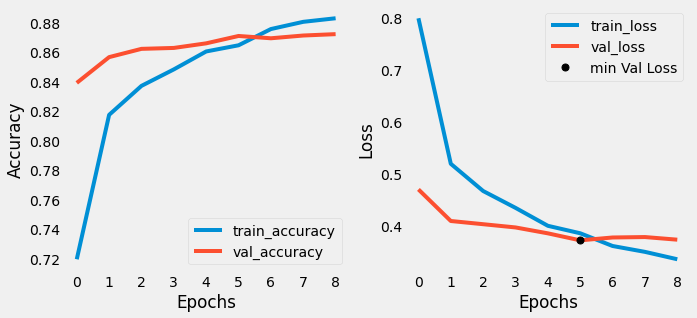

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(train_acc, label='train_accuracy')
plt.plot(val_acc, label='val_accuracy')
plt.grid([])
plt.xticks(range(val_acc.size))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right', fontsize=14)
plt.subplot(2,2,2)
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.plot(np.argmin(val_loss), np.min(val_loss), 'ok', markersize=7, label='min Val Loss')
plt.grid([])
plt.xticks(range(val_loss.size))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right', fontsize=14)
plt.show()

In [21]:
model_checkpoint.best_model_path

'/kaggle/working/checkpoints/epoch=5.ckpt'

In [22]:
best_path = os.path.join('./checkpoints', os.path.basename(model_checkpoint.best_model_path))
new_model = CassavaModel.load_from_checkpoint(best_path)

In [23]:
torch.save(new_model, './cassava_model_effnet_b3ns.pt')

In [24]:
y_val = trainer.test(new_model,test_dataloaders=val_loader, verbose=False)

In [25]:
from sklearn.metrics import accuracy_score
pred = np.concatenate([x['y_hat'] for x in y_val], axis=0)
pred = np.argmax(pred, axis=1)
accuracy_score(val.label.values, pred)

0.8707165109034268

In [26]:
shutil.rmtree("./lightning_logs")

In [28]:
shutil.rmtree("./checkpoints")